# Anti-Spam Detection System for Univerisity

In this project, an analysis is performed on a dataset containing both secure emails and spam emails in order to achieve the following objectives:
- Train a classifier to identify spam
- Identify the main topics among the spam emails in the dataset
- Calculate the semantic distance between the obtained topics to infer their heterogeneity
- Extract the organizations present in the secure (non-spam) emails

In particular a classifier model was developed to distinguish between spam and non-spam emails using the capabilities of recurrent neural networks. Subsequently the Latent Dirichlet Allocation model was applied to identify the main topics discussed in spam emails, enabling automatic grouping of communications based on common terms. Moreover the semantic distance between the various identified topics was evaluated, providing an overview of the heterogeneity of spam contents. Finally, using an NLP model from spaCy, organization entities were extracted from non-spam emails, allowing for automatic identification of company or institution words.

## Sources

Text Cleaning: https://monkeylearn.com/blog/text-cleaning/ <br>
Vocabulary Words Number: https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2016.01116/full <br>
Topic Selection: https://medium.com/@trantphuongthao99/topic-modelling-crafting-an-lda-model-with-python-for-analyzing-dialogue-in-the-friends-sitcom-9527bd3fd442

## Environment Settings

In [8]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Libraries

Packages versions used for this project: <br>
* TensorFlow 2.13.1 <br>
* Keras 2.13.1 <br>
* H5py 3.11.0

In [11]:
# Legacy Keras 2.x
os.environ['TF_USE_LEGACY_KERAS'] = '1'

# Import core libraries and display versions
import tensorflow, keras, h5py
print(f"TensorFlow version: {tensorflow.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"H5py version: {h5py.__version__}")

TensorFlow version: 2.13.1
Keras version: 2.13.1
H5py version: 3.11.0


In [12]:
# Data
import pandas as pd
import numpy as np

# Utility
import random
import re
import pickle
import joblib
from pprint import pprint

# Plot
import seaborn as sns
from matplotlib import pyplot as plt

# Language
import nltk
import spacy
import gensim
import gensim.downloader
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from scipy import spatial

# Preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import precision_score, recall_score,accuracy_score, f1_score, log_loss
from sklearn.metrics import confusion_matrix, classification_report

# Keras
from keras.backend import clear_session
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, SimpleRNN, LSTM, GRU, Bidirectional
from keras.callbacks import EarlyStopping

## Constants

In [14]:
# Random seeds for reproducibility
RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Result value set in case of division by zero
ZERO_DIVISION = 0

# Number of parallel jobs (-1: maximum parallelism)
N_JOBS = -1

# Folders
FOLDER_DATASETS = "Datasets/"
FOLDER_MODELS = "Models/"

## Global Variables

In [16]:
# Notebook settings
LOAD_TRAINED_MODELS = True

# Process settings
TOKENIZER_WORDS_NUMBER = 42000      # number of tokenized words in the vocabulary
TEST_SIZE_RATIO = 0.2               # ratio for test data for train-test split
SIGMOID_PREDICTION_THRESHOLD = 0.5  # probability threshold to select target class from sigmoid output

## Functions

#### Utilities

In [19]:
 def prediction(model, X_train, X_test):
    
    """ Evaluate and return the predicted values and related probabilities for target for train and test sets """
    
    if type(model) == type(Sequential()):
        print("Model prediction:")
    
    # Train
    y_pred_train = model.predict(X_train)
    
    if type(model) != type(Sequential()):
        y_proba_train = model.predict_proba(X_train)
    else:
        y_proba_train = None

    # Test
    y_pred_test = model.predict(X_test)
    
    if type(model) != type(Sequential()):
        y_proba_test = model.predict_proba(X_test)
    else:
        y_proba_test = None

    return y_pred_train, y_proba_train, y_pred_test, y_proba_test


def show_classification_report(y, y_pred, title = None):
    if title != None:
        print(f"\n# {title} - Metrics #")
    print(classification_report(y, y_pred))


def model_metrics(y_true, y_pred, y_proba):
    """
    Receive real and predicted target values from a classification model and
    return the related precision, recall, accuracy, F1 score and log loss metrics.
    """

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Metrics evaluation
    precision = precision_score(y_true, y_pred, zero_division = ZERO_DIVISION) 
    recall = recall_score(y_true, y_pred, zero_division = ZERO_DIVISION)       
    accuracy = (cm[0, 0] + cm[1,1])/np.sum(cm)  
    f1 = f1_score(y_true, y_pred, zero_division = ZERO_DIVISION)
    if y_proba is not None:
        log_loss_value = log_loss(y_true, y_proba)
    else:
        log_loss_value = None
    
    return precision, recall, accuracy, f1, log_loss_value
    

def plot_confusion_matrix(y_true, y_pred, y_proba = None, display_metrics = False, labels = ["Negative", "Positive"], title = None):
    """
    Plot confusion matrix using real and predicted target values from a classification model.
    Optionally display the related precision, recall and accuracy metrics.
    """

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #    0   1
    # 0 TN  FP
    # 1 FN  TP

    # Convert confusion matrix to dataframe and create the related heatmap
    df_cm = pd.DataFrame(cm, index = labels, columns = ["Predicted " + labels[0], "Predicted " + labels[1]])     
    sns.heatmap(df_cm, annot = True, fmt = "g") # fmt = "g" -> no scientific notation

    # Add info and show plot
    if title != None:
        plt.title(title) 
    if display_metrics:
        precision, recall, accuracy, _, _ = model_metrics(y_true, y_pred, y_proba)      
        plt.text(0, -0.2, f"Precision: {precision:.3f}") # TP/(TP + FP)
        plt.text(1, -0.2, f"Recall: {recall:.3f}")       # TP/(TP + FN)     
        plt.text(1.9, -0.2, f"Accuracy: {accuracy:.3f}") # (TP + TN)/(TP + FP + TN + FN)    
    plt.show()

#### Text Utilities

In [21]:
def show_unique_characters(df_feature = []):
    """ Show unique characters from an input dataset column """
    
    # Concatenate all comments in one string
    all_texts = ' '.join(df_feature)
    
    # Obtain the set of unique characters
    unique_characters = set(all_texts)
    
    # Show unique characters
    print(unique_characters)
    
    
def remove_stopwords(text, stopwords):
    """ Remove stopwords from input text and return processed text """

    # Split input text
    words = text.split()

    # Remove words if among stopwords 
    filtered_words = [word for word in words if word not in stopwords]

    # Concatenate again the input text
    cleaned_text = ' '.join(filtered_words)
    
    return cleaned_text


def lemmatize_text(text, lemmatizer):
    """ Apply lemmatization to input text and return processed text """

    # Split input text
    words = text.split()

    # Apply lemmatization to each word
    lemma_words = []
    for word in words:
        lemma_words.append(lemmatizer.lemmatize(word))

    # Concatenate again the input text
    lemma_text = ' '.join(lemma_words)
    
    return lemma_text

#### Models

In [23]:
def generate_logistic_regressor(# Model info
                                model_name = "",
                                targets_number = 1,
                                targets_names = None,

                                # Model data
                                X_train = [], Y_train = [],
                                X_test = [], Y_test = [],
                                
                                # LogisticRegression hyperparameters
                                class_weight = None,
                                regularization = 'l2',
                                max_iter = 100,
                                               
                                # Preprocessing parameters
                                scaler = None,
                                sampler = None,
                                sampling_strategy = None,
                                               
                                # Random seed for reproducibility
                                random_state = None,
                                                                                
                                # Metrics display option
                                show_metrics = False,
                                show_confusion_matrix = False,
                                metrics_report = False,
                                  
                                # Model loading flag
                                load_trained_model = False):
    
    """
    Create a logistic regressor model receiving features and target split for hold-out validation.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    
    Return the pipeline of trained model and related metrics.
    """

    # Model settings and training
    if not load_trained_model:
        
        # Pipeline steps settings
        pipe_steps = []
        
        # Scaling
        if scaler == 'Standard':   
            # Standardization
            pipe_steps.append(('scaler', StandardScaler()))    
        elif scaler == 'MinMax':      
            # Normalization
            pipe_steps.append(('scaler', MinMaxScaler()))
        else:    
            # No data scaling applied
            pass
        
        # Undersampling
        if sampler == "RandomUnderSampler" and sampling_strategy != '':
            rus = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = random_state)
            pipe_steps.append(('undersampler', rus))
        
        # Oversampling
        if sampler == "RandomOverSampler" and sampling_strategy != '':
            ros = RandomOverSampler(sampling_strategy = sampling_strategy, random_state = random_state)
            pipe_steps.append(('oversampler', ros))
            
        # Regularization
        if regularization != None:   
            penalty = regularization
            if regularization == "l1":
                solver = 'liblinear'
                np.random.seed(random_state) # to force liblinear to exploit random_state seed
            else:
                solver = 'lbfgs' # default
        else:
            solver = 'lbfgs' # default
    
        # Logistic regression settings
        lr = LogisticRegression(class_weight = class_weight, penalty = penalty, solver = solver, max_iter = max_iter)
        pipe_steps.append(('logistic_regression', lr))
           
        # Pipeline creation
        pipeline = Pipeline(pipe_steps)
        
        # Multi-classifier creation
        multi_target_classifier = MultiOutputClassifier(pipeline, n_jobs = N_JOBS)
        
        # Model training
        multi_target_classifier.fit(X_train, Y_train)

        # Store model pipeline
        joblib.dump(multi_target_classifier, FOLDER_MODELS + "model_" + model_name + ".pkl")
        print(f"\nTraining finished!\n")

    # Loading
    else:

        # Load model pipeline
        multi_target_classifier = joblib.load(FOLDER_MODELS + "model_" + model_name + ".pkl")
        print(f"\nModel {model_name} already trained is loaded\n")

    # Predictions
    Y_pred_train, Y_proba_train, Y_pred_test, Y_proba_test = prediction(multi_target_classifier, X_train, X_test)

    # Metrics
    if show_metrics:
        show_classification_report(Y_train, Y_pred_train, title = "Train Set")
        show_classification_report(Y_test, Y_pred_test, title = "Test Set")

    # Define metrics dataframe
    df_metrics = pd.DataFrame(columns = ['target', 'precision', 'recall', 'accuracy', 'f1'])

    # Cycle all target classes
    for i in range(targets_number):
        
        # Confusion matrix
        if show_confusion_matrix:
            if targets_names is not None:
                target_title = targets_names[i]
            plot_confusion_matrix(Y_train[:, i], Y_pred_train[:, i], Y_proba_train[i],
                                  display_metrics = True, title = "Train Set - '" + target_title + "'")
            plot_confusion_matrix(Y_test[:, i],  Y_pred_test[:, i],  Y_proba_test[i],
                                  display_metrics = True, title = "Test Set - '" + target_title + "'")

        # Metrics report
        if metrics_report:
            precision, recall, accuracy, f1, _ = model_metrics(Y_train[:, i], Y_pred_train[:, i], Y_proba_train[i])
            new_row_values = [targets_names[i], precision, recall, accuracy, f1]
            df_metrics.loc[len(df_metrics)] = new_row_values
      
    return multi_target_classifier, df_metrics

In [24]:
def train_and_evaluate_rnn_model( # Model info
                                  model_name = "",
                                  model_type = 'Simple',
                                  targets_number = 1,
                                  targets_names = None,
                                  
                                  # Model data
                                  X_train = [], Y_train = [],
                                  X_test = [], Y_test = [],
    
                                  # Layer sizes
                                  input_dim = 1,        # size of input layer
                                  input_length = 1,     # size of input data point
                                  dense_output_dim = 1, # size of output layer
    
                                  # Training hyperparameters
                                  epochs = 5,
                                  batch_size = 32,
    
                                  # Metrics display option
                                  show_metrics = False,
                                  show_confusion_matrix = False,
                                  metrics_report = False,
                                   
                                  # Model loading flag
                                  load_trained_model = False):

        
    """
    Create a recurrent neural network model receiving features and target split for hold-out validation.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    
    Return the model weights, training history and related metrics.
    """
    
    # Clear Keras session
    clear_session()

    # Model creation
    model = Sequential()
    model.add(Embedding(input_dim = input_dim, output_dim = 128, input_length = input_length))
    
    # Recurrent layer selection
    if model_type == 'Simple':
        model.add(SimpleRNN(units = 64, activation = 'tanh'))
    elif model_type == 'LSTM':
        model.add(LSTM(units = 64, activation = 'tanh'))
    elif model_type == 'GRU':
        model.add(GRU(units = 64, activation = 'tanh'))
    elif model_type == 'Bidirectional':
        model.add(Bidirectional(LSTM(units = 64, activation = 'tanh')))
    else:
        model.add(SimpleRNN(units = 64, activation = 'tanh'))
    
    # Output layer
    model.add(Dense(units = dense_output_dim, activation = 'sigmoid'))

    # Model structure
    model.summary()

    # Model compilation
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = 'accuracy') # rmsprop optimizer is suggested to prevent vanishing gradient

    # Model path
    model_path = FOLDER_MODELS + "model_" + model_name + ".weights.h5"

    # Training
    if not load_trained_model:
        
        # Callback for early stopping
        early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, mode = 'auto', restore_best_weights = True)

        # Model training
        print(f"\nTraining of model {model_name} started:\n")
        history = model.fit(x = X_train, y = Y_train, validation_split = 0.2, epochs = epochs, batch_size = batch_size, callbacks = [early_stopping])
    
        # Model evaluation
        print(f"\nModel evaluation:\n")
        model.evaluate(x = X_test, y = Y_test)
        
        # Store model
        model.save_weights(model_path)
        pickle.dump(history.history, open(FOLDER_MODELS + "history_" + model_name + ".pkl", 'wb'))
        print(f"\nTraining finished!\n")

    # Loading
    else:

        # Load model
        model.load_weights(model_path)
        history = pickle.load(open(FOLDER_MODELS + "history_" + model_name + ".pkl", 'rb'))
        print(f"\nModel {model_name} already trained is loaded\n")
        
    # Predictions
    Y_pred_train, _, Y_pred_test, _ = prediction(model, X_train, X_test)
    
    # Define metrics dataframe
    df_metrics = pd.DataFrame(columns = ['target', 'precision', 'recall', 'accuracy', 'f1'])

    # Cycle all target classes
    for i in range(targets_number):

        # Extract true and predicted values for current target class
        y_train = Y_train[:, i]
        y_pred_train = Y_pred_train[:, i] > SIGMOID_PREDICTION_THRESHOLD
        y_test = Y_test[:, i]
        y_pred_test = Y_pred_test[:, i] > SIGMOID_PREDICTION_THRESHOLD

        # Metrics
        if show_metrics:
            show_classification_report(y_train, y_pred_train, title = "Train Set")
            show_classification_report(y_test, y_pred_test, title = "Test Set")

        # Confusion matrix
        if show_confusion_matrix:
            
            # Set title
            if targets_names is not None:
                target_title = " - " + targets_names[i]
            else:
                target_title = ''
            
            # Plot matrix
            plot_confusion_matrix(y_true = y_train, y_pred = y_pred_train, y_proba = None, display_metrics = True, title = "Train Set" + target_title)
            plot_confusion_matrix(y_true = y_test, y_pred = y_pred_test, y_proba = None, display_metrics = True, title = "Test Set" + target_title)

        # Metrics report
        if metrics_report:
            precision, recall, accuracy, f1, _ = model_metrics(y_true = y_test, y_pred = y_pred_test, y_proba = None)
            new_row_values = [targets_names[i], precision, recall, accuracy, f1]
            df_metrics.loc[len(df_metrics)] = new_row_values
                                 
    return model, history, df_metrics

## 1 - Data Exploration

In [26]:
# Import the dataset
df = pd.read_csv(FOLDER_DATASETS + "spam_dataset.csv")

In [27]:
# Check the beginning of the dataset
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [28]:
# Show dataframe size, columns names and variables types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [29]:
## Double-check that target label actually matches the encoded one ##

# Create a dataframe with only the labels columns
df_labels = df[['label', 'label_num']]

# Group all the univoque combinations and count the occurrences
df_labels_counts = df_labels.groupby(df_labels.columns.tolist(), as_index = False).size()

# Display the classes cardinalities in descending order
df_labels_counts.sort_values(by = 'size', ascending = False, ignore_index = True)

,label,label_num,size
0,ham,0,3672
1,spam,1,1499


Since all occurrences of 'label' = "spam" are matching the occurrences of 'label_name' = 1 (and same for "ham" with 0), this latter columns can be considered as already encoded target

## 2 - Preprocessing

In [32]:
# Preserve original dataset
df_preprocess = df.copy()

In [33]:
# Drop unnecessary columns
df_preprocess = df_preprocess.drop(['Unnamed: 0', 'label'], axis = 1)
df_preprocess.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\nth...,0
1,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\nthis deal is to ...,0


### 2.1 - Text Cleaning

#### Display All Unique Characters

In [36]:
# Show the list of unique characters
show_unique_characters(df_preprocess['text'])

{'$', 'p', '8', '!', 'c', ',', '=', 'h', '"', '?', '[', '9', 'e', 'u', '\n', '0', 'f', ')', 'v', ':', '6', ' ', '(', '&', 'x', '3', "'", '1', 'g', '\x1b', 'i', '5', '\x13', '}', '#', '^', 'z', '\x07', 'b', '.', '+', '*', '|', 'y', '/', 'S', '-', '`', ';', '~', '_', '2', 'j', '<', '{', '>', 'm', 'a', '\x12', '\x14', '%', 't', 'l', '\\', '4', 'o', 'r', 'n', '\x11', '\x05', ']', 'd', '7', '\x0f', 'w', 's', '\x16', '\x01', '@', 'k', 'q'}


#### Normalize Text

In [38]:
# Convert to lower case
df_preprocess['text'] = df_preprocess['text'].apply(lambda x: x.lower())
df_preprocess['text'].head()

0    subject: enron methanol ; meter # : 988291\nth...
1    subject: hpl nom for january 9 , 2001\n( see a...
2    subject: neon retreat\nho ho ho , we ' re arou...
3    subject: photoshop , windows , office . cheap ...
4    subject: re : indian springs\nthis deal is to ...
Name: text, dtype: object

#### Replace Newlines and Tabulations

In [40]:
# Regular expression for newline and tab character
regex_newline_tab = r'[\n\t]'

# Replace the special characters with a space
df_preprocess['text'] = df_preprocess['text'].str.replace(regex_newline_tab, ' ', regex = True)
df_preprocess['text'].head()

0    subject: enron methanol ; meter # : 988291 thi...
1    subject: hpl nom for january 9 , 2001 ( see at...
2    subject: neon retreat ho ho ho , we ' re aroun...
3    subject: photoshop , windows , office . cheap ...
4    subject: re : indian springs this deal is to b...
Name: text, dtype: object

#### Remove Unwanted Unicode Characters

In [42]:
# Regular expression to keep alphanumeric characters and spaces and to remove tags, URLs and hyperlinks
regex_unicode = re.compile(r"([^0-9A-Za-z ])|(@\[A-Za-z0-9]+)|(\w+:\/\/\S+)|http.+?")

# Apply regular expression replacing not allowed symbols and strings with a space
df_preprocess['text'] = df_preprocess['text'].str.replace(regex_unicode, ' ', regex = True)
df_preprocess['text'].head()

0    subject  enron methanol   meter     988291 thi...
1    subject  hpl nom for january 9   2001   see at...
2    subject  neon retreat ho ho ho   we   re aroun...
3    subject  photoshop   windows   office   cheap ...
4    subject  re   indian springs this deal is to b...
Name: text, dtype: object

#### Verify Remaining Characters

In [44]:
# Show the list of unique characters
show_unique_characters(df_preprocess['text'])

{' ', 'n', 'x', 'v', '3', 'd', '6', '1', 'g', 'p', '8', '7', 'c', 'y', 'h', 'w', 'i', 's', '2', '5', 'j', '9', 'm', 'e', 'z', 'a', 'u', 'b', '0', 'k', 'f', 't', 'l', '4', 'o', 'q', 'r'}


#### Remove Stopwords

In [46]:
# Download stopwords from Natural Language Toolkit
nltk.download('stopwords')

# Select stopwords for english language
stopwords_eng = nltk.corpus.stopwords.words('english')

# Show words to be removed
print(stopwords_eng)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tripxer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
# Remove stopwords from the dataset
df_preprocess['text'] = df_preprocess['text'].apply(lambda x: remove_stopwords(x, stopwords = stopwords_eng))
df_preprocess['text'].head()

0    subject enron methanol meter 988291 follow not...
1    subject hpl nom january 9 2001 see attached fi...
2    subject neon retreat ho ho ho around wonderful...
3    subject photoshop windows office cheap main tr...
4    subject indian springs deal book teco pvr reve...
Name: text, dtype: object

#### Lemmatization

In [49]:
# Download lexical database
nltk.download('wordnet')
nltk.download('omw-1.4')

# Istantiate the lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

# Apply lemmatization to the dataset
df_preprocess['text'] = df_preprocess['text'].apply(lambda x: lemmatize_text(x, lemmatizer = lemmatizer))
df_preprocess['text'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tripxer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Tripxer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0    subject enron methanol meter 988291 follow not...
1    subject hpl nom january 9 2001 see attached fi...
2    subject neon retreat ho ho ho around wonderful...
3    subject photoshop window office cheap main tre...
4    subject indian spring deal book teco pvr reven...
Name: text, dtype: object

In [50]:
# Remove first word "subject", since present in all the data and hence not bringing any information
def remove_first_word(row, word_to_remove = ""):
    
    # Split row in words
    words = row.split()
    
    # Exclude first word if equal to the one to be removed
    if words[0] == word_to_remove:
        new_row = ' '.join(words[1:])
    else:
        new_row = row
    
    return new_row

# Apply function to remove the first unuseful word
df_preprocess['text'] = df_preprocess['text'].apply(lambda x: remove_first_word(x, "subject"))

In [51]:
# Store of preprocessed dataset
df_preprocess.to_csv(FOLDER_DATASETS + "dataset_preprocessed.csv", index = False)

### 2.2 - Vocabulary

In [53]:
# Tokenize with the average number of lemmas known by a english speaker 
tokenizer = Tokenizer(num_words = TOKENIZER_WORDS_NUMBER)

In [54]:
# Create a vocabulary from comment
tokenizer.fit_on_texts(df_preprocess['text'])

In [55]:
# Check number of entries
tokenizer.document_count

5171

In [56]:
## Show the 10 most frequent words ##

# Extract first words from dictionary already ordered by frequency
top_words = [tokenizer.index_word[i] for i in range(1, 11)]

# Extract words frequencies
word_counts = tokenizer.word_counts
word_frequencies = [word_counts[word] for word in top_words]

# Create a dataframe to print a tabulated output
df_top_words = pd.DataFrame({'Lemma': top_words, 'Frequency': word_frequencies}, index = range(1, 11))
print(df_top_words)

      Lemma  Frequency
1       ect      13908
2       hou       7289
3     enron       6555
4      2000       4386
5       com       3709
6      deal       3635
7    please       3198
8       gas       3036
9         3       2922
10  subject       2891


In [57]:
# Vocabulary size
vocabulary_size = len(tokenizer.word_index) + 1 # 1 character reserved for padding
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 47897


### 2.3 - Sequences

In [59]:
# Create sequences exploiting tokenized words
sequences = tokenizer.texts_to_sequences(df_preprocess['text'])

In [60]:
# Show the first encoded texts...
for sequence in sequences[:5]:
    print(sequence)

[3, 792, 12, 11413, 560, 229, 1666, 313, 30, 9, 13, 1638, 95, 353, 573, 22, 7, 6591, 453, 117, 27, 1667, 511, 1032, 117, 219, 2710, 8, 363, 51, 399, 1306, 3563, 890]
[17, 80, 193, 64, 20, 46, 54, 92, 1784, 77, 58, 1784, 77, 58]
[1241, 6592, 7300, 7300, 7300, 623, 3884, 52, 148, 1241, 1215, 6592, 52, 28, 52, 148, 2515, 8187, 5670, 209, 483, 576, 1379, 561, 136, 576, 143, 300, 105, 193, 11, 103, 209, 934, 22608, 14974, 699, 2005, 5671, 6592, 502, 644, 193, 31, 59, 3564, 5288, 2136, 2388, 6083, 2644, 143, 301, 51, 201, 106, 644, 193, 40, 177, 329, 390, 24, 209, 209, 584, 781, 38, 42, 827, 52, 6084, 2389, 42, 1639, 1108, 5671, 834, 2452, 3123, 38, 42, 994, 311, 2137, 912, 2388, 1425, 828, 1731, 42, 827, 644, 47, 28, 2952, 141, 434, 56, 6592, 1426, 400, 576, 744, 148, 148, 121, 136, 22609, 700, 9377, 90, 5, 1732, 11414, 2390, 308, 177, 8188, 31, 8188, 1394, 800, 800, 700, 610, 11415, 89, 731, 11414, 63, 244, 86, 934, 1539, 1488, 14975, 6593, 1109, 11414, 2645, 3342, 827, 635, 2391, 52, 688,

In [61]:
# ...and the decoded ones
texts = tokenizer.sequences_to_texts(sequences)
for text in texts[:5]:
    print(text)

enron methanol meter 988291 follow note gave monday 4 3 00 preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purpose
hpl nom january 9 2001 see attached file hplnol 09 xl hplnol 09 xl
neon retreat ho ho ho around wonderful time year neon leader retreat time know time year extremely hectic tough think anything past holiday life go past week december 25 january 1 like think minute calender handed beginning fall semester retreat scheduled weekend january 5 6 youth minister conference brad dustin connected week going change date following weekend january 12 13 come part need think think agree important u get together time recharge battery get far spring semester lot trouble difficult u get away without kid etc brad came potential alternative get together weekend let know prefer first option would retreat similar done past several year year could go heartland country inn www com outside

#### Sequences Padding

In [63]:
# Lenght of longest sequence
sequence_maximum_length = len(max(sequences, key = len))
sequence_maximum_length

3474

In [64]:
# Padding sequences shorter than longest one prepending a 0
padded_sequences = pad_sequences(sequences, maxlen = sequence_maximum_length)

## 3 - Modeling

As a reference baseline, a simple logistic regression model is trained by setting class balancing. Then different types of recurrent neural networks will be trained and their performances will be compared afterward.

#### Features and Target Selection

In [68]:
# Select features and target
X = padded_sequences
y = df_preprocess['label_num'].values.reshape(-1, 1)

In [69]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE_RATIO, stratify = y, random_state = RANDOM_SEED)

In [70]:
# Check train and test sizes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4136, 3474), (4136, 1), (1035, 3474), (1035, 1))

In [71]:
# Target info
classes_number = 1
classes_names = ["Spam"]

### 3.0 - Baseline Logistic Regressor Model


Model LogRegr already trained is loaded


# Train Set - Metrics #
              precision    recall  f1-score   support

           0       0.95      0.30      0.46      2937
           1       0.36      0.96      0.52      1199

    accuracy                           0.49      4136
   macro avg       0.66      0.63      0.49      4136
weighted avg       0.78      0.49      0.48      4136


# Test Set - Metrics #
              precision    recall  f1-score   support

           0       0.74      0.26      0.38       735
           1       0.30      0.78      0.43       300

    accuracy                           0.41      1035
   macro avg       0.52      0.52      0.41      1035
weighted avg       0.61      0.41      0.40      1035



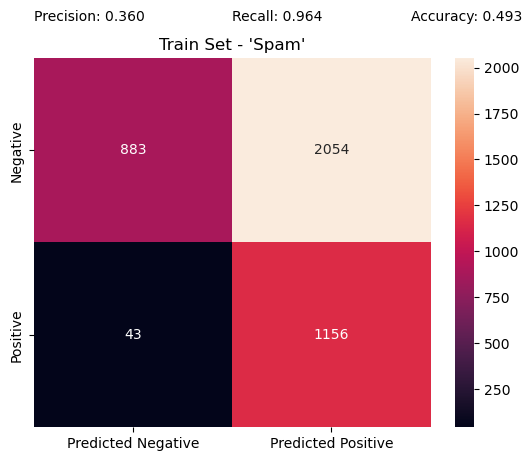

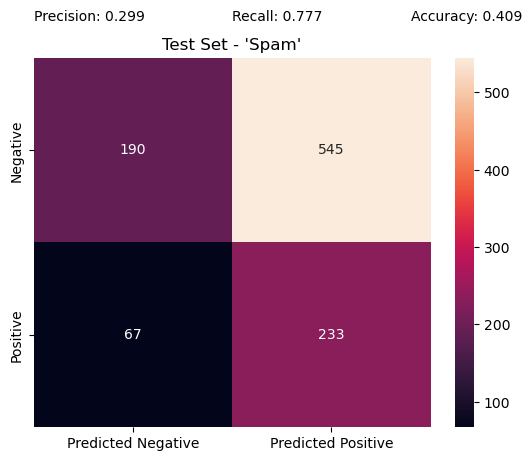

In [73]:
model_lr, metrics_lr = generate_logistic_regressor(# Model info
                                       model_name = "LogRegr",
                                       targets_number = classes_number,
                                       targets_names = classes_names,
    
                                       # Model data
                                       X_train = X_train, Y_train = y_train,
                                       X_test = X_test, Y_test = y_test,
    
                                       # LogisticRegression hyperparameters
                                       class_weight = 'balanced',
                                       max_iter = 500,

                                       # Random seed for reproducibility
                                       random_state = RANDOM_SEED,
    
                                       # Metrics display option
                                       show_metrics = True,
                                       show_confusion_matrix = True,
                                       metrics_report = True,
    
                                       # Model loading flag
                                       load_trained_model = LOAD_TRAINED_MODELS)

### 3.1 - Simple Recurrent Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3474, 128)         6130816   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6143233 (23.43 MB)
Trainable params: 6143233 (23.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model RNN already trained is loaded

Model prediction:
33/33 [==============================] - 9s 281ms/step

# Train Set - Metrics #
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2937
           1       0.98      0.99      0.99      1199

    accuracy                           0.99      4136
   macro avg       0.99      0.99      0.99      4136
weighted avg       0.99      0.99      0.99      4136


# Test Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       735
           1       0.95      0.97      0.96       300

    accuracy                           0.98      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



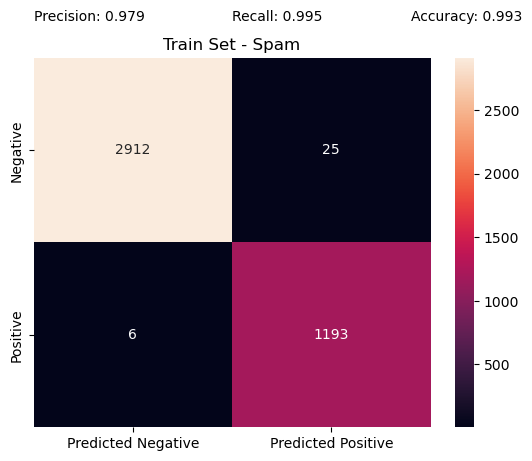

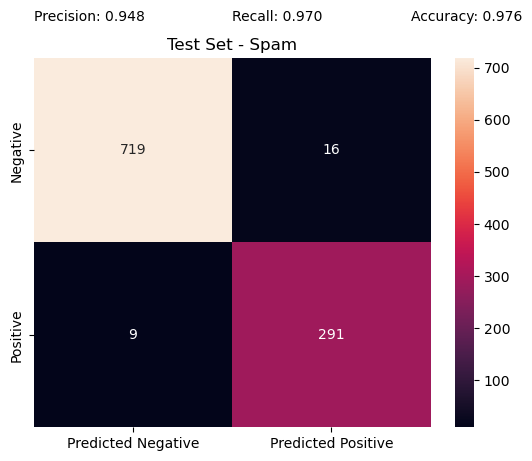

In [75]:
model_rnn, history_rnn, metrics_rnn = train_and_evaluate_rnn_model(
                                      # Model info
                                      model_name = "RNN",
                                      model_type = 'Simple',
                                      targets_number = classes_number,
                                      targets_names = classes_names,
        
                                      # Model data
                                      X_train = X_train, Y_train = y_train,
                                      X_test = X_test, Y_test = y_test,
        
                                      # Layer sizes
                                      input_dim = vocabulary_size,
                                      input_length = sequence_maximum_length,
                                      dense_output_dim = classes_number,
            
                                      # Training hyperparameters
                                      epochs = 100,
                                      batch_size = 1024,
        
                                      # Metrics display option
                                      show_metrics = True,
                                      show_confusion_matrix = True,
                                      metrics_report = True,
        
                                      # Model loading flag
                                      load_trained_model = LOAD_TRAINED_MODELS)

### 3.2 - Long Short-Term Memory

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3474, 128)         6130816   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6180289 (23.58 MB)
Trainable params: 6180289 (23.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model LSTM already trained is loaded

Model prediction:
33/33 [==============================] - 25s 760ms/step

# Train Set - Metrics #
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2937
           1       0.98      0.99      0.99      1199

    accuracy                           0.99      4136
   macro avg       0.99      0.99      0.99      4136
weighted avg       0.99      0.99      0.99      4136


# Test Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       735
           1       0.96      0.99      0.97       300

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



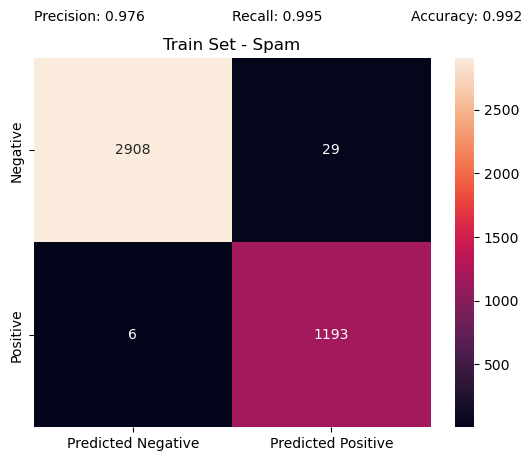

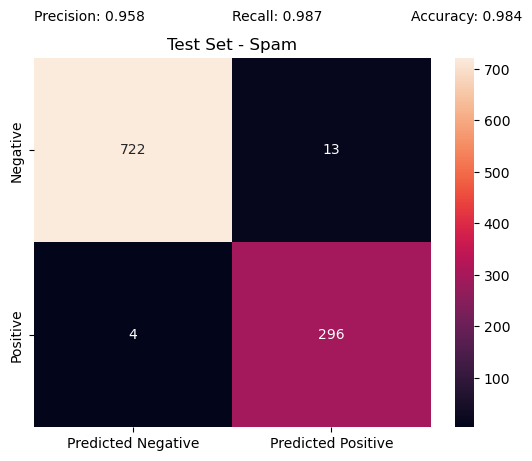

In [77]:
model_lstm, history_lstm, metrics_lstm = train_and_evaluate_rnn_model(
                                          # Model info
                                          model_name = "LSTM",
                                          model_type = 'LSTM',
                                          targets_number = classes_number,
                                          targets_names = classes_names,
                
                                          # Model data
                                          X_train = X_train, Y_train = y_train,
                                          X_test = X_test, Y_test = y_test,
                
                                          # Layer sizes
                                          input_dim = vocabulary_size,
                                          input_length = sequence_maximum_length,
                                          dense_output_dim = classes_number,
                
                                          # Training hyperparameters
                                          epochs = 100,
                                          batch_size = 1024,
                
                                          # Metrics display option
                                          show_metrics = True,
                                          show_confusion_matrix = True,
                                          metrics_report = True,
                
                                          # Model loading flag
                                          load_trained_model = LOAD_TRAINED_MODELS)

### 3.3 - Gate Recurrent Unit

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3474, 128)         6130816   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6168129 (23.53 MB)
Trainable params: 6168129 (23.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model GRU already trained is loaded

Model prediction:
33/33 [==============================] - 17s 520ms/step


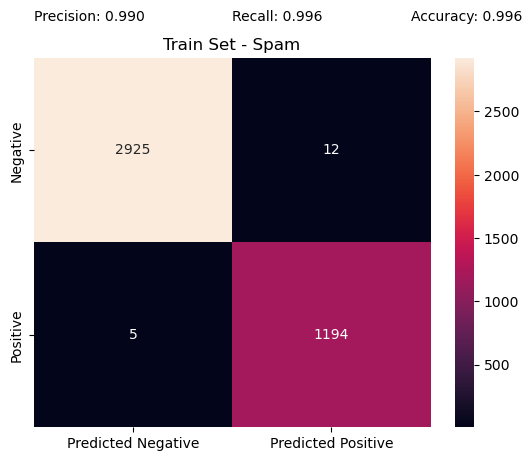

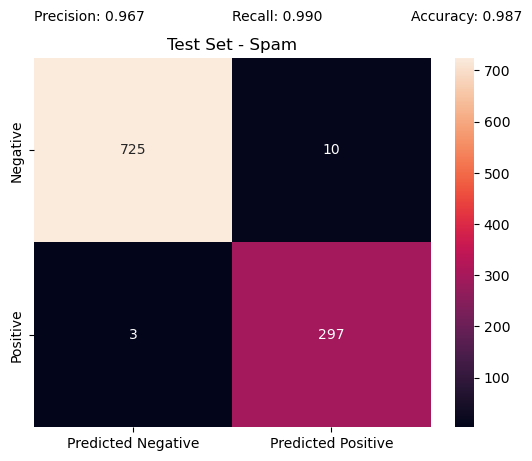

In [79]:
model_gru, history_gru, metrics_gru = train_and_evaluate_rnn_model(
                                      # Model info
                                      model_name = "GRU",
                                      model_type = 'GRU',
                                      targets_number = classes_number,
                                      targets_names = classes_names,
        
                                      # Model data
                                      X_train = X_train, Y_train = y_train,
                                      X_test = X_test, Y_test = y_test,
        
                                      # Layer sizes
                                      input_dim = vocabulary_size,
                                      input_length = sequence_maximum_length,
                                      dense_output_dim = classes_number,
            
                                      # Training hyperparameters
                                      epochs = 100,
                                      batch_size = 1024,
        
                                      # Metrics display option
                                      show_metrics = False,
                                      show_confusion_matrix = True,
                                      metrics_report = True,
        
                                      # Model loading flag
                                      load_trained_model = LOAD_TRAINED_MODELS)

### 3.4 - Bidirectional LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3474, 128)         6130816   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 6229761 (23.76 MB)
Trainable params: 6229761 (23.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model BiLSTM already trained is loaded

Model prediction:
33/33 [==============================] - 73s 2s/step


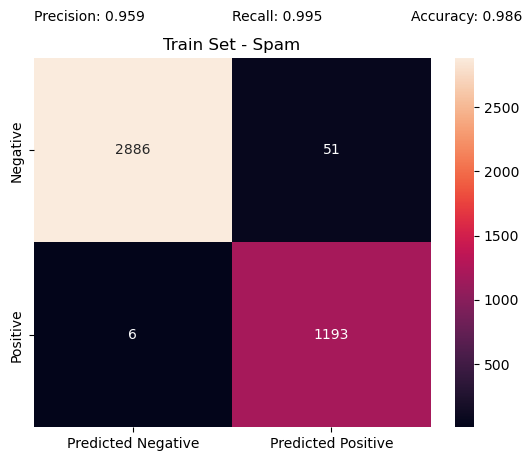

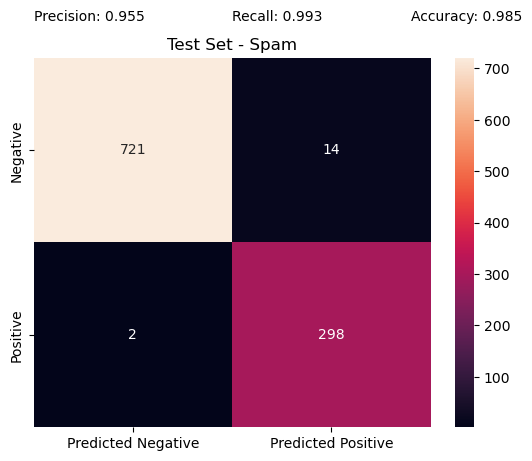

In [81]:
model_bilstm, history_bilstm, metrics_bilstm = train_and_evaluate_rnn_model(
                                                  # Model info
                                                  model_name = "BiLSTM",
                                                  model_type = 'Bidirectional',
                                                  targets_number = classes_number,
                                                  targets_names = classes_names,
                    
                                                  # Model data
                                                  X_train = X_train, Y_train = y_train,
                                                  X_test = X_test, Y_test = y_test,
                    
                                                  # Layer sizes
                                                  input_dim = vocabulary_size,
                                                  input_length = sequence_maximum_length,
                                                  dense_output_dim = classes_number,
                        
                                                  # Training hyperparameters
                                                  epochs = 100,
                                                  batch_size = 1024,
                    
                                                  # Metrics display option
                                                  show_metrics = False,
                                                  show_confusion_matrix = True,
                                                  metrics_report = True,
                    
                                                  # Model loading flag
                                                  load_trained_model = LOAD_TRAINED_MODELS)

## 4 - Model Selection

In [83]:
# List with all models metrics
models_metrics = [metrics_lr, metrics_rnn, metrics_lstm, metrics_gru, metrics_bilstm]

# Models names
models_names = ["LogRegr", "RNN", "LSTM", "GRU", "BiLSTM"]

# Concatenate all models metrics in unique dataframe
df_metrics = pd.concat(models_metrics, ignore_index = True)

# Remove unuseful column
df_metrics.drop('target', axis = 1, inplace = True)

# Add models names
df_metrics.insert(0, 'model', models_names)

# Show metrics summary
round(df_metrics, 3)

,model,precision,recall,accuracy,f1
0,LogRegr,0.360,0.964,0.493,0.524
1,RNN,0.948,0.970,0.976,0.959
2,LSTM,0.958,0.987,0.984,0.972
3,GRU,0.967,0.990,0.987,0.979
4,BiLSTM,0.955,0.993,0.985,0.974


The recurrent neural network models all demonstrate excellent performance, similar to each other and superior than the logistic regressor used as baseline. Given the importance of both detecting spam emails and not mistakenly blocking safe ones, accuracy is considered the most indicative metric of the model's quality. Therefore, the GRU is chosen as the best model.

## 5 - Training History

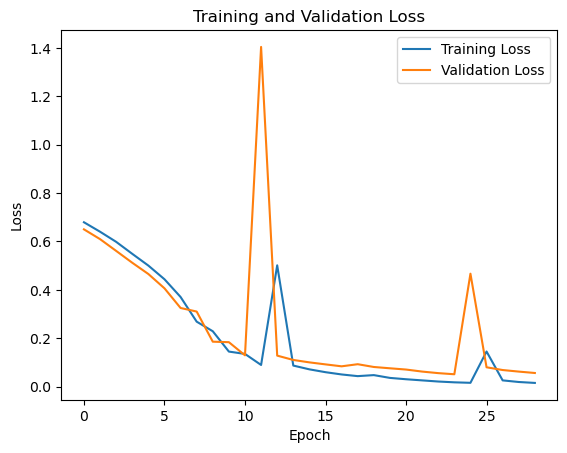

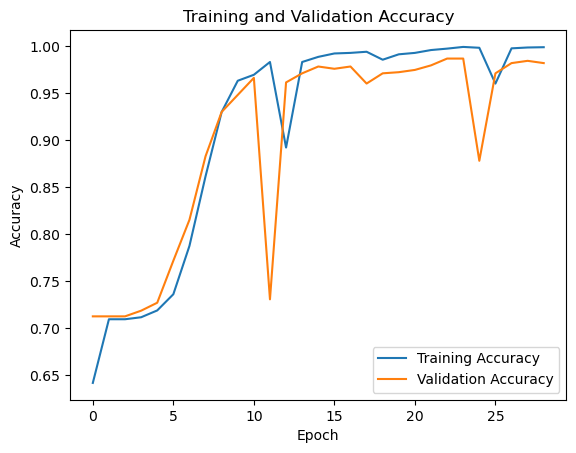

In [86]:
def plot_training_history(history):
    
    # Loss plot
    plt.plot(history['loss'], label = 'Training Loss')
    plt.plot(history['val_loss'], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Accuracy plot
    plt.plot(history['accuracy'], label = 'Training Accuracy')
    plt.plot(history['val_accuracy'], label = 'Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Plot training history for loss and accuracy
plot_training_history(history_gru)

Observing the training history, it can be seen that despite some spikes in loss and accuracy deterioration, the training converged towards its optimal performance.

## 6 - Detect Main Spam Topics

To detect the main topics among spam mails, the LDA (Latent Dirichlet Allocation) model is used to uncover latent topics by analyzing the distribution of terms within the documents. It identifies topics based on the probability of certain terms co-occurring within the mails, allowing the inference of specific topics from the term distribution.

Since the LDA model requires in advance the number of topics to consider, a coherence model is also used to evaluate the quality of topics by varying their number. By measuring the semantic similarity between terms, the coherence model helps to determine the optimal number of topics, preventing over or under aggregation of topics. The 'c_v' metric combines contextual and semantic similarity, proving effective for evaluating topic coherence.

In [90]:
# Select only spam mails
df_spam = df_preprocess[df_preprocess['label_num'] == 1]
df_spam.drop('label_num', axis = 1, inplace = True)
df_spam

,text
3,photoshop window office cheap main trending ab...
7,looking medication best source difficult make ...
10,vocable rnd word asceticism vcsc brand new sto...
11,report 01405 wffur attion brom est inst siupie...
13,vic odin n ow berne hotbox carnal bride cutwor...
...,...
5159,picture streamlined denizen ajar chased heaven...
5161,penny stock timing nomad international inc ndi...
5162,anomaly boy 3881 uosda apaproved mledms heure ...
5164,slutty milf want meet take ilaa liqaa


In [91]:
# Convert dataframe to list
spam_mails_list = df_spam['text'].tolist()

# Tokenize all mail documents in split words
spam_words_list = [mails.split() for mails in spam_mails_list]

# Dictionary of spam mails words
id_to_word = corpora.Dictionary(spam_words_list)

# Bag-of-Words vectorization of spam words
corpus = [id_to_word.doc2bow(word) for word in spam_words_list]

In [92]:
# Set range of number of topics
min_topics = 2
max_topics = 30
step_size = 1
topics_range = range(min_topics, max_topics + 1, step_size)

# Coherence score list
coherence_scores = []

# LDA training and coherence evaluation for each topics number
for num_topics in topics_range:
    
    # LDA model
    lda_model = gensim.models.LdaMulticore(corpus = corpus,
                                           id2word = id_to_word,
                                           num_topics = num_topics,
                                           passes = 10, # number of steps
                                           random_state = RANDOM_SEED) 
    
    # Coherence evaluation
    coherence_model_lda = CoherenceModel(model = lda_model,
                                         texts = spam_words_list,
                                         dictionary = id_to_word,
                                         coherence = 'c_v')
    
    # Get and append coherence score to the list
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

In [93]:
# Find the optimal number of topics with the highest coherence score
optimal_num_topics = topics_range[np.argmax(coherence_scores)]
print("Optimal number of topics:", optimal_num_topics)
print("Coherence score:", round(max(coherence_scores), 3))

Optimal number of topics: 5
Coherence score: 0.578


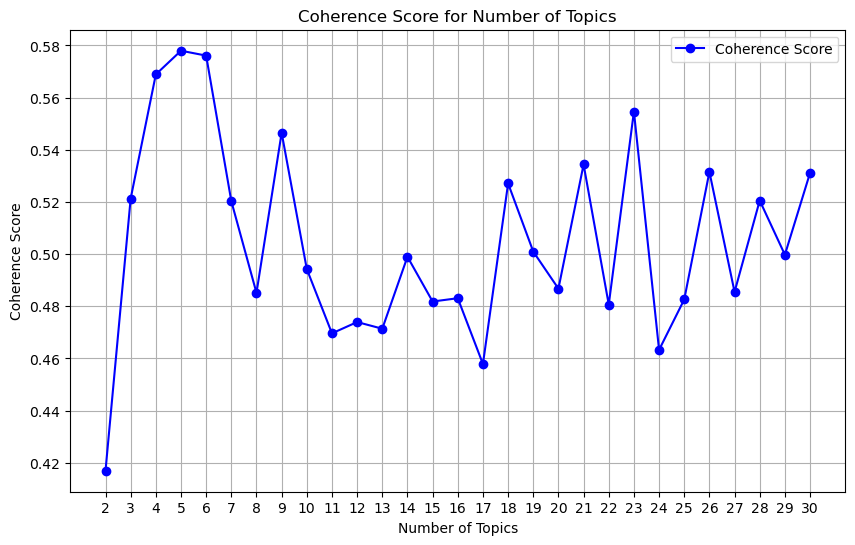

In [94]:
# Plotting the relationship between the number of topics and coherence score
plt.figure(figsize = (10, 6))
plt.plot(topics_range, coherence_scores, marker = 'o', color = 'b', label = "Coherence Score")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score for Number of Topics")
plt.xticks(topics_range)
plt.legend()
plt.grid(True)
plt.show()

In [95]:
# Train LDA model with topics number related to best topics coherence
lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = id_to_word, num_topics = optimal_num_topics, passes = 10, random_state = RANDOM_SEED)

# Show topics and most representive words (and relative weights) relative to the topic
pprint(lda_model.print_topics())

[(0,
  '0.005*"com" + 0.004*"e" + 0.004*"2" + 0.004*"cialis" + 0.003*"c" + '
  '0.003*"8" + 0.003*"soft" + 0.003*"3" + 0.003*"tab" + 0.003*"get"'),
 (1,
  '0.008*"pill" + 0.007*"99" + 0.006*"00" + 0.004*"com" + 0.004*"1" + '
  '0.003*"60" + 0.003*"u" + 0.003*"www" + 0.003*"90" + 0.003*"0"'),
 (2,
  '0.011*"company" + 0.006*"statement" + 0.005*"stock" + 0.005*"information" + '
  '0.004*"security" + 0.004*"price" + 0.004*"may" + 0.004*"investment" + '
  '0.003*"within" + 0.003*"report"'),
 (3,
  '0.015*"3" + 0.012*"td" + 0.012*"font" + 0.009*"height" + 0.008*"width" + '
  '0.007*"0" + 0.006*"size" + 0.006*"align" + 0.006*"tr" + 0.006*"2"'),
 (4,
  '0.008*"com" + 0.007*"nbsp" + 0.007*"00" + 0.006*"u" + 0.006*"e" + '
  '0.005*"price" + 0.005*"3" + 0.005*"computron" + 0.005*"2" + 0.005*"1"')]


<br> From the aggregated terms, the following main topics can be inferred:
* Topic 0: sale of medicine for erectile dysfunction ("cialis", "get").
* Topic 1: online offers about general medicines ("pill", "www").
* Topic 2: business and financial offers ("company", "stock", "security", "information", "investment").
* Topic 3: mails containing HTML formatting or document structure ("td", "font", "nbsp", "height", "width", "tr").
* Topic 4: mixture of promotional and informational content ("com", "nbsp", "price", "computron").

## 7 - Evaluation of Semantic Distance Among Spam Topics

To assess the heterogeneity of the extracted topics, the pretrained model 'word2vec-google-news-300' is used. Since this model is trained on a wide range of news texts, it may provide a semantic representation of the most common words in the context of spam emails.

In [99]:
# Load Google news model vector
word2vec_vector_model = gensim.downloader.load('word2vec-google-news-300')

# words vector size
WORDS_VECTOR_SIZE = 300

In [100]:
def evaluate_average_vector(vector_model = None, words = [], words_vector_size = 1):
        
    # Initialize sum vector
    sum_vector = np.zeros(words_vector_size)
    
    # Number of words not included in the model to be excluded for average calculation
    number_not_included_words = 0
      
    # Cycle all words in the list
    for word in words:
        
        # If the word is present in vector model
        if word in vector_model.key_to_index.keys():
            
            # Add vector value to sum vector
            sum_vector += vector_model.get_vector(word)
            
        else:
            
            # Increment the number of missing words
            number_not_included_words += 1

    # If no words are present, set average vector with all zeros
    if len(words) == number_not_included_words:
        average_vector = np.zeros(words_vector_size)
        
    else:
        
        # Calculate average vector
        average_vector = sum_vector/(len(words) - number_not_included_words)
        
    return average_vector

In [101]:
# Average topics vector lists
topics_vector = []

# Evaluate average vector for each topic
for topic in lda_model.print_topics():
    
    # Split topic words and relative weights
    topic_elements = topic[1].split('"')
    
    # Extract only topic words which are in odd positions
    topic_words = topic_elements[1::2]
    
    # Evaluate average vector
    topic_average_vector = evaluate_average_vector(word2vec_vector_model, topic_words, WORDS_VECTOR_SIZE)
    
    # Append average vector
    topics_vector.append(topic_average_vector)

In [102]:
# Initialize similarity matrix as a 2D array of zeros
similarity_matrix = np.zeros((len(topics_vector), len(topics_vector)))

# Evaluate similarity calculating cosine distance among each vectors couple
for i, vector_a in enumerate(topics_vector):
    for j, vector_b in enumerate(topics_vector):
        similarity_matrix[i][j] = 1 - spatial.distance.cosine(topics_vector[i], topics_vector[j])

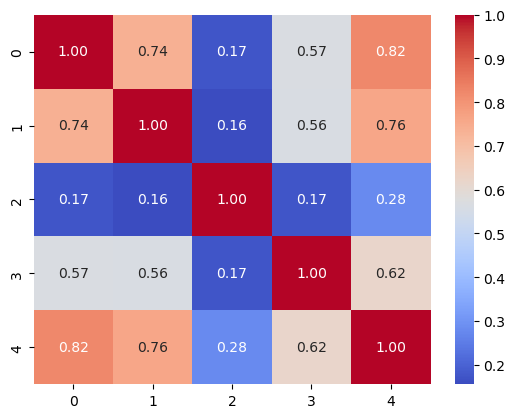

In [103]:
# Create the heatmap with value display
sns.heatmap(similarity_matrix, cmap = 'coolwarm', annot = True, fmt = ".2f")

# Display the heatmap
plt.show()

The diagonally symmetric matrix provides an indication of similarity between all pairs of topics, obtained by calculating distances between the average vectorizations of the predominant terms in each topic. For instance, Topic 0 is considered highly similar to Topic 4, indicating a significant overlap in key terms. Conversely, Topic 0 is markedly different from Topic 2, indicating little mutual correlation.

## 8 - Organizations Entities Among Non-Spam Mails

The "en_core_web_sm" model from spaCy was used to extract entities of type "organization" from emails. This pre-trained model for English enables automatic recognition and classification of entities such as company names, institutions or other organizations found in the email text.

In [107]:
# Select only non-spam mails
df_safe_mail = df_preprocess[df_preprocess['label_num'] == 0]
df_safe_mail.drop('label_num', axis = 1, inplace = True)

# Convert dataframe to list
safe_mails = df_safe_mail['text'].tolist()
safe_mails[:5]

['enron methanol meter 988291 follow note gave monday 4 3 00 preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purpose',
 'hpl nom january 9 2001 see attached file hplnol 09 xl hplnol 09 xl',
 'neon retreat ho ho ho around wonderful time year neon leader retreat time know time year extremely hectic tough think anything past holiday life go past week december 25 january 1 like think minute calender handed beginning fall semester retreat scheduled weekend january 5 6 youth minister conference brad dustin connected week going change date following weekend january 12 13 come part need think think agree important u get together time recharge battery get far spring semester lot trouble difficult u get away without kid etc brad came potential alternative get together weekend let know prefer first option would retreat similar done past several year year could go heartland country inn www c

In [108]:
def extract_entity(nlp_model = None, text = "", target_entity = ''):
    
    # Target entity list      
    entity_words = []
   
    # Extract text tokens
    tokenized_document = nlp_model(text)

    # Cycle all token in the document
    for token in tokenized_document:
        
        # Append the token text if beloging to target entity
        if str(token.ent_type_) == target_entity:
            entity_words.append(token.text)
                
    return entity_words

In [109]:
# Target entity
target_entity = 'ORG'

# Load spacy model
nlp_model = spacy.load('en_core_web_sm')

# Entity words count dictionary
words_count_dict = {}

# NER over mails
for mail in safe_mails:
    
    # Extract entity from mail
    entity_words = extract_entity(nlp_model, mail, target_entity) 
    
    # If there are words related to target entity
    if len(entity_words) > 0:
        
        # For each word in the entity list
        for entity_word in entity_words:
     
            # Add the word in the dictionary and update its occurrency count 
            words_count_dict[entity_word] = words_count_dict.get(entity_word, 0) + 1

In [110]:
# Reorder the organizations count to show the most frequent ones
word_count_sorted = sorted(words_count_dict.items(), key = lambda x: x[1], reverse = True)

# Show top 10 organizations
for organization, count in word_count_sorted[:10]:
    print(f"{organization}: {count}")

enron: 2382
corp: 1274
tenaska: 297
chokshi: 207
pat: 202
clynes: 196
inc: 156
hpl: 142
actuals: 133
l: 119


## 9 - Final Considerations

Thanks to the use of recurrent neural networks, the model developed has proven to be very effective in distinguishing between safe emails and spam, both during training and testing phases. Regarding instead the topic aggregation phase, despite being assisted by the coherence score evaluation, there was a certain variability both in identifying the optimal number of topics (which did not show a significantly higher score compared to other possible numbers) and in the resulting topics, whose key terms varied significantly during training even for minor changes as the random seed used for the LdaMulticore model.